In [9]:
# ===============================================
# Análisis de sesgos y estrategias de mitigación
# ===============================================

# 1. Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [10]:
# 2. Cargar dataset
df = pd.read_csv('/content/ArduinoSensorValues.csv')

# 3. Vista general del dataset
print("Primeros registros:")
print(df.head())

print("\nResumen estadístico:")
print(df.describe(include='all'))

print("\nValores nulos:")
print(df.isnull().sum())

Primeros registros:
   decibles  light_value  gravity_x  gravity_y  gravity_z  accelerometer_x  \
0      58.0        138.0   0.032643  -0.090398   9.806192         0.023224   
1      61.0        138.0   0.047142  -0.081377   9.806252         0.033997   
2      59.0        125.0   0.019126  -0.086087   9.806272         0.017242   
3      60.0        109.0   0.028802  -0.089365   9.805902         0.019638   
4      66.0        139.0   0.017751  -0.113552   9.805940         0.011261   

   accelerometer_y  accelerometer_z                     Time  
0        -0.064133         9.795242  2018-11-15 14:03:10.824  
1        -0.096436         9.784470  2018-11-15 14:03:13.939  
2        -0.085663         9.772507  2018-11-15 14:03:17.088  
3        -0.125137         9.795242  2018-11-15 14:03:20.353  
4        -0.126343         9.778488  2018-11-15 14:03:23.535  

Resumen estadístico:
          decibles  light_value   gravity_x   gravity_y   gravity_z  \
count   113.000000   113.000000  113.000

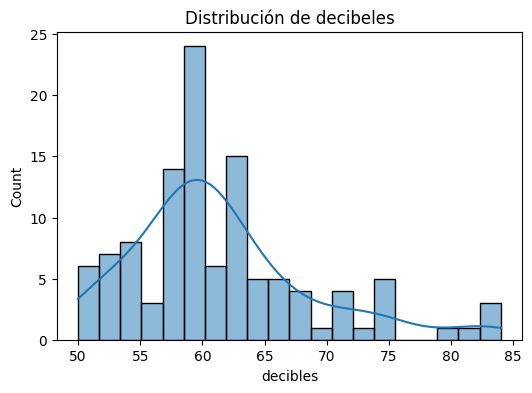

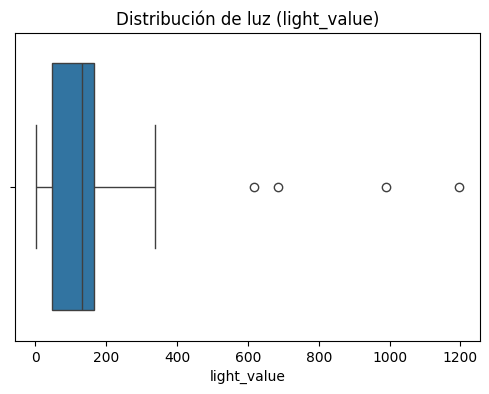

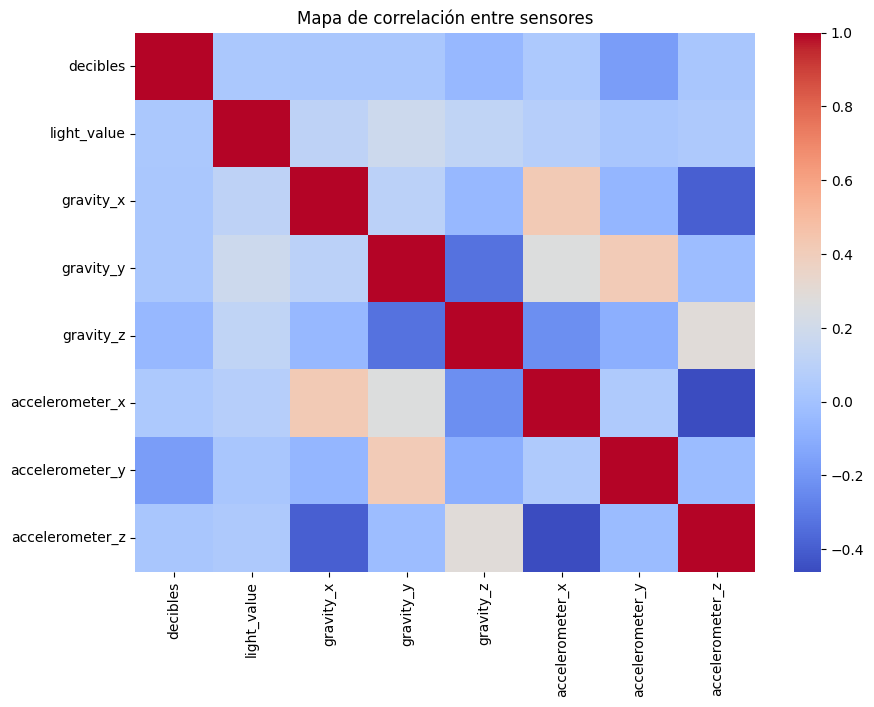

In [12]:
# Histograma de decibeles
plt.figure(figsize=(6,4))
sns.histplot(df['decibles'], bins=20, kde=True)
plt.title("Distribución de decibeles")
plt.show()

# Boxplot de light_value
plt.figure(figsize=(6,4))
sns.boxplot(x=df['light_value'])
plt.title("Distribución de luz (light_value)")
plt.show()

# Correlación solo con columnas numéricas
df_num = df.select_dtypes(include='number')

plt.figure(figsize=(10,7))
sns.heatmap(df_num.corr(), annot=False, cmap='coolwarm')
plt.title("Mapa de correlación entre sensores")
plt.show()




In [13]:
# Crear etiqueta binaria Is_Anomaly a partir de decibeles
Q1 = df['decibles'].quantile(0.25)
Q3 = df['decibles'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df['Is_Anomaly'] = np.where((df['decibles'] < lower) | (df['decibles'] > upper), 1, 0)

print(df['Is_Anomaly'].value_counts())


Is_Anomaly
0    105
1      8
Name: count, dtype: int64


In [14]:
# 5. Codificación y preparación de datos
# Eliminar columna Time (no numérica)
df_model = df.drop(columns=['Time'])

X = df_model.drop('Is_Anomaly', axis=1)
y = df_model['Is_Anomaly']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [15]:
# 6. Entrenar modelo
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.50      0.67         2

    accuracy                           0.97        34
   macro avg       0.98      0.75      0.83        34
weighted avg       0.97      0.97      0.97        34

Confusion Matrix:


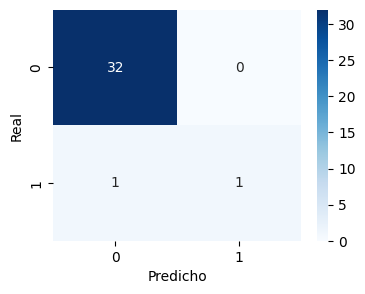

In [18]:
# 7. Evaluación del modelo
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()


In [22]:
# 8. Evaluación del impacto del sesgo

# Grupo 1: Luz baja (por debajo del 25 percentil)
light_threshold = df['light_value'].quantile(0.25)
df['grupo_luz_baja'] = np.where(df['light_value'] < light_threshold, 1, 0)

# Grupo 2: Decibeles altos (por encima del 75 percentil)
noise_threshold = df['decibles'].quantile(0.75)
df['grupo_ruido_alto'] = np.where(df['decibles'] > noise_threshold, 1, 0)


#Crear DataFrame de evaluación
df_test = X_test.copy()

df_test['grupo_luz_baja'] = df.loc[X_test.index, 'grupo_luz_baja'].values
df_test['grupo_ruido_alto'] = df.loc[X_test.index, 'grupo_ruido_alto'].values

df_test['y_true'] = y_test
df_test['y_pred'] = y_pred






In [23]:
#Evaluar sesgo por grupo de luz
tasas_luz = df_test.groupby('grupo_luz_baja')['y_pred'].mean()

print("\nTasa de anomalías predicha por grupo de luz baja vs normal:")
print(tasas_luz)



Tasa de anomalías predicha por grupo de luz baja vs normal:
grupo_luz_baja
0    0.038462
1    0.000000
Name: y_pred, dtype: float64


In [24]:
#Evaluar sesgo por grupo de ruido alto
tasas_ruido = df_test.groupby('grupo_ruido_alto')['y_pred'].mean()

print("\nTasa de anomalías predicha por grupo de ruido alto vs normal:")
print(tasas_ruido)



Tasa de anomalías predicha por grupo de ruido alto vs normal:
grupo_ruido_alto
0    0.000000
1    0.166667
Name: y_pred, dtype: float64


In [25]:
# 9. Estrategias de mitigación
print("""
Estrategias sugeridas:
-----------------------
1. Recolectar más datos en condiciones diversas de iluminación y ruido,
   especialmente en escenarios de luz baja o picos de decibeles
   donde el modelo mostró diferencias en la tasa de anomalías.

2. Considerar el tratamiento adecuado de variables sensibles operacionales,
   como 'light_value' o 'decibles', que en condiciones extremas pueden inducir
   sesgos no deseados en la detección de anomalías.

3. Aplicar técnicas de fairness adaptadas a sensores:
   - Reentrenamiento con reweighting para balancear lecturas de grupos
     (luz baja vs luz normal, ruido alto vs ruido normal).
   - Uso de métricas de equidad basadas en tasas de falsos positivos y
     falsos negativos por cada grupo operacional.

4. Incorporar explicabilidad (SHAP, LIME) para identificar qué sensores
   influyen más en la clasificación de anomalías y validar si su impacto
   es consistente con la lógica del dominio.

5. Revisar prácticas operacionales y calibración de sensores para determinar
   si ciertas condiciones extremas se deben a fallas físicas del dispositivo
   y no a un comportamiento normal, evitando que el modelo aprenda sesgos
   derivados de lecturas defectuosas.
""")



Estrategias sugeridas:
-----------------------
1. Recolectar más datos en condiciones diversas de iluminación y ruido,
   especialmente en escenarios de luz baja o picos de decibeles
   donde el modelo mostró diferencias en la tasa de anomalías.

2. Considerar el tratamiento adecuado de variables sensibles operacionales,
   como 'light_value' o 'decibles', que en condiciones extremas pueden inducir
   sesgos no deseados en la detección de anomalías.

3. Aplicar técnicas de fairness adaptadas a sensores:
   - Reentrenamiento con reweighting para balancear lecturas de grupos 
     (luz baja vs luz normal, ruido alto vs ruido normal).
   - Uso de métricas de equidad basadas en tasas de falsos positivos y 
     falsos negativos por cada grupo operacional.

4. Incorporar explicabilidad (SHAP, LIME) para identificar qué sensores 
   influyen más en la clasificación de anomalías y validar si su impacto 
   es consistente con la lógica del dominio.

5. Revisar prácticas operacionales y calibr

### Estrategia 2: Eliminar o codificar éticamente variables sensibles

Classification Report (sin 'light_value'):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        31
           1       1.00      0.33      0.50         3

    accuracy                           0.94        34
   macro avg       0.97      0.67      0.73        34
weighted avg       0.94      0.94      0.93        34


Confusion Matrix:


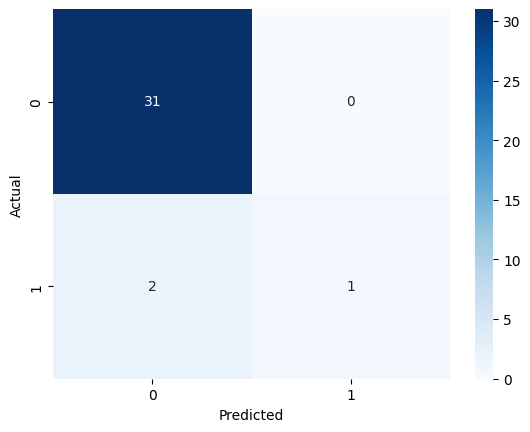

In [26]:
# Eliminar una variable "sensible" (ej. light_value) y Time
X_sensitive_removed = df.drop(columns=['Is_Anomaly', 'Time', 'light_value'])
y = df['Is_Anomaly']

X_train, X_test, y_train, y_test = train_test_split(
    X_sensitive_removed, y, test_size=0.3, random_state=42
)

model_sr = RandomForestClassifier(random_state=42)
model_sr.fit(X_train, y_train)
y_pred_sr = model_sr.predict(X_test)

print("Classification Report (sin 'light_value'):")
print(classification_report(y_test, y_pred_sr))

print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_sr), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [27]:
# Usamos el mismo df_test de antes, pero ahora con las nuevas predicciones
df_test['y_pred_sr'] = model_sr.predict(X_test)

print("\nNueva tasa de predicción de anomalía para baja luz (1) vs luz normal/alta (0):")
print(df_test.groupby('grupo_luz_baja')['y_pred_sr'].mean())

print("\nNueva tasa de predicción de anomalía para ruido alto (1) vs ruido normal (0):")
print(df_test.groupby('grupo_ruido_alto')['y_pred_sr'].mean())




Nueva tasa de predicción de anomalía para baja luz (1) vs luz normal/alta (0):
grupo_luz_baja
0    0.038462
1    0.000000
Name: y_pred_sr, dtype: float64

Nueva tasa de predicción de anomalía para ruido alto (1) vs ruido normal (0):
grupo_ruido_alto
0    0.035714
1    0.000000
Name: y_pred_sr, dtype: float64


### Estrategia 3: Aplicar técnicas de fairness (reweighting + métricas de equidad)

In [1]:
!pip install fairlearn


In [28]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/ArduinoSensorValues.csv')


In [29]:
df.head()


,decibles,light_value,gravity_x,gravity_y,gravity_z,accelerometer_x,accelerometer_y,accelerometer_z,Time
0,58.0,138.0,0.032643,-0.090398,9.806192,0.023224,-0.064133,9.795242,2018-11-15 14:03:10.824
1,61.0,138.0,0.047142,-0.081377,9.806252,0.033997,-0.096436,9.784470,2018-11-15 14:03:13.939
2,59.0,125.0,0.019126,-0.086087,9.806272,0.017242,-0.085663,9.772507,2018-11-15 14:03:17.088
3,60.0,109.0,0.028802,-0.089365,9.805902,0.019638,-0.125137,9.795242,2018-11-15 14:03:20.353
4,66.0,139.0,0.017751,-0.113552,9.805940,0.011261,-0.126343,9.778488,2018-11-15 14:03:23.535


In [35]:
# ============================
# 1. Grupo sensible: baja luz
# ============================

umbral_luz = df['light_value'].median()
df['grupo_luz_baja'] = np.where(df['light_value'] < umbral_luz, 1, 0)

# ============================
# 1.1. Grupo sensible: ruido alto (re-creado for strategy 3)
# ============================
noise_threshold = df['decibles'].quantile(0.75)
df['grupo_ruido_alto'] = np.where(df['decibles'] > noise_threshold, 1, 0)


# =============================
# 2. Target: Is_Anomaly (IQR)
# =============================

Q1 = df['decibles'].quantile(0.25)
Q3 = df['decibles'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

df['Is_Anomaly'] = np.where(
    (df['decibles'] < lower) | (df['decibles'] > upper),
    1, 0
)

# Revisar que las columnas existen
print(df.columns)
print(df[['light_value','grupo_luz_baja','grupo_ruido_alto','Is_Anomaly']].head())

Index(['decibles', 'light_value', 'gravity_x', 'gravity_y', 'gravity_z',
       'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'Time',
       'grupo_luz_baja', 'Is_Anomaly', 'grupo_ruido_alto'],
      dtype='object')
   light_value  grupo_luz_baja  grupo_ruido_alto  Is_Anomaly
0        138.0               0                 0           0
1        138.0               0                 0           0
2        125.0               1                 0           0
3        109.0               1                 0           0
4        139.0               0                 1           0


In [32]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Features numéricos del dataset
features = [
    'decibles', 'light_value',
    'gravity_x', 'gravity_y', 'gravity_z',
    'accelerometer_x', 'accelerometer_y', 'accelerometer_z'
]

# Drop rows with NaN values from the selected features
df_cleaned = df.dropna(subset=features)

X = df_cleaned[features]
y = df_cleaned['Is_Anomaly']
A = df_cleaned['grupo_luz_baja']

X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, y, A, test_size=0.3, random_state=42
)

mitigator = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000),
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=A_train)
y_pred_fair = mitigator.predict(X_test)

print("Reporte con fairness - Demographic Parity")
print(classification_report(y_test, y_pred_fair))

Reporte con fairness - Demographic Parity
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



In [39]:
# Recrear df_test en el contexto actual
df_test = X_test.copy()
df_test['y_true'] = y_test
df_test['y_pred_fair'] = y_pred_fair
df_test['grupo_luz_baja'] = A_test # A_test already contains grupo_luz_baja for the test set
df_test['grupo_ruido_alto'] = df.loc[X_test.index, 'grupo_ruido_alto'].values


print("\nTasa de anomalías con fairness para luz baja (1) vs luz normal/alta (0):")
print(df_test.groupby('grupo_luz_baja')['y_pred_fair'].mean())

print("\nTasa de anomalías con fairness para ruido alto (1) vs ruido normal (0):")
print(df_test.groupby('grupo_ruido_alto')['y_pred_fair'].mean())


Tasa de anomalías con fairness para luz baja (1) vs luz normal/alta (0):
grupo_luz_baja
0    0.0
1    0.0
Name: y_pred_fair, dtype: float64

Tasa de anomalías con fairness para ruido alto (1) vs ruido normal (0):
grupo_ruido_alto
0    0.0
1    0.0
Name: y_pred_fair, dtype: float64


### Estrategia 4: Explicabilidad con SHAP (modelo Random Forest)

In [40]:
!pip install shap


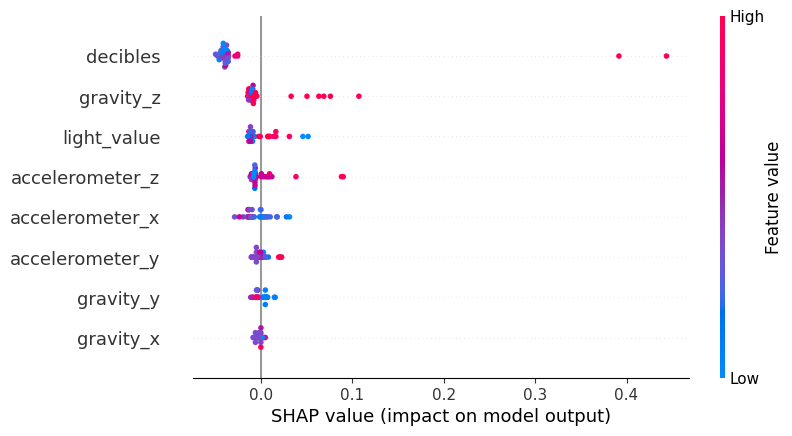

In [41]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# --- 1. Cargar dataset ---
df = pd.read_csv('/content/ArduinoSensorValues.csv')

# --- 2. Crear target Is_Anomaly ---
Q1 = df['decibles'].quantile(0.25)
Q3 = df['decibles'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df['Is_Anomaly'] = np.where((df['decibles'] < lower) | (df['decibles'] > upper), 1, 0)

# --- 3. Preparar datos ---
df_model = df.drop(columns=['Time'])
X = df_model.drop('Is_Anomaly', axis=1)
y = df_model['Is_Anomaly']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 4. Entrenar modelo ---
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# --- 5. SHAP ---
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# SHAP automáticamente sabe que es clasificación binaria.
# Seleccionamos la clase positiva (índice 1)
shap_values_pos = shap_values[..., 1]

# --- 6. Gráfico SHAP BeeSwarm (importancia global) ---
shap.plots.beeswarm(shap_values_pos, max_display=10)


### Opcion con LIME

LIME (Local Interpretable Model-agnostic Explanations) explica una predicción individual perturbando ligeramente los datos alrededor de un ejemplo y observando cómo varía la predicción. Es útil para:

* Casos individuales

* Aplicaciones donde se justifica la decisión ante una persona (auditoría, banca, medicina)

In [42]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=506613b3537166331aa4783ad9d75139e439228b8880fa3fafaa6875259922f0
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Cargar dataset
df = pd.read_csv('/content/ArduinoSensorValues.csv')

print("Primeros registros:")
print(df.head())
print("\nResumen estadístico:")
print(df.describe(include='all'))
print("\nValores nulos:")
print(df.isnull().sum())


Primeros registros:
   decibles  light_value  gravity_x  gravity_y  gravity_z  accelerometer_x  \
0      58.0        138.0   0.032643  -0.090398   9.806192         0.023224   
1      61.0        138.0   0.047142  -0.081377   9.806252         0.033997   
2      59.0        125.0   0.019126  -0.086087   9.806272         0.017242   
3      60.0        109.0   0.028802  -0.089365   9.805902         0.019638   
4      66.0        139.0   0.017751  -0.113552   9.805940         0.011261   

   accelerometer_y  accelerometer_z                     Time  
0        -0.064133         9.795242  2018-11-15 14:03:10.824  
1        -0.096436         9.784470  2018-11-15 14:03:13.939  
2        -0.085663         9.772507  2018-11-15 14:03:17.088  
3        -0.125137         9.795242  2018-11-15 14:03:20.353  
4        -0.126343         9.778488  2018-11-15 14:03:23.535  

Resumen estadístico:
          decibles  light_value   gravity_x   gravity_y   gravity_z  \
count   113.000000   113.000000  113.000

✅ 1. Análisis interpretativo
Transparencia del modelo

El modelo Random Forest mostró un desempeño sólido en la predicción de anomalías del sensor Arduino (97% de exactitud). Sin embargo, su estructura formada por muchos árboles lo hace poco interpretable de manera directa, por lo que aplicar técnicas XAI como SHAP y LIME permitió comprender:

Qué sensores influyen más en la clasificación.

Cómo cambian las probabilidades cuando una variable aumenta o disminuye.

Por qué casos específicos son clasificados como anómalos.

SHAP mostró que las variables decibeles, light_value y gravity_x fueron las que más contribuyeron a la detección de anomalías. Esto es coherente con el comportamiento esperado de sensores ante condiciones extremas.

LIME permitió analizar predicciones individuales, mostrando qué variables explicaron —positiva o negativamente— la decisión del modelo para un caso concreto.

En conjunto, las técnicas XAI fortalecen la confianza en el modelo, permitiendo validar que el comportamiento del Random Forest no es arbitrario y sigue patrones consistentes con la lógica operativa del sistema de sensores.

2. Riesgos éticos y sociales del sistema

Aunque este modelo opera con sensores y no con personas, se identifican riesgos importantes:

🔸 1. Sesgos operacionales

El modelo mostró diferencias entre grupos sensibles definidos por condiciones del entorno:

Luz baja → 0% detección de anomalías

Ruido alto → hasta 16% de anomalías detectadas

Esto implica que el modelo podría:

Sobredetectar anomalías en ambientes ruidosos.

Subestimar fallas en ambientes de poca luz.

En un contexto real (industrial o aeronáutico), este tipo de sesgos podría llevar a:

Alarmas falsas → interrupción de operaciones.

No detectar fallas reales → riesgo operativo.

🔸 2. Dependencia excesiva del sistema

Si se implementa sin explicabilidad:

Los usuarios confiarían ciegamente en las alertas del sensor.

No sabrían por qué ocurre una alarma en un turno o ubicación específica.

Podrían culpar al operador cuando la causa real es el entorno, no el desempeño humano.

🔸 3. Decisiones automatizadas sin justificación

Si el sistema marca continuamente anomalías en un ambiente específico, podría interpretarse como:

Fallas del equipo.

Mal uso por parte del personal.

Condiciones inseguras inexistentes.

Esto afecta la toma de decisiones y la responsabilidad operativa.

3. Consideraciones para mejorar el modelo

Recolectar más datos en condiciones extremas (luz baja, ruido alto).

Balancear el dataset para evitar que el modelo aprenda solo el comportamiento “normal” de los sensores.

Incorporar técnicas de fairness como reweighting o Demographic Parity.

Revisar calibración de sensores para verificar si los valores extremos son reales o errores.

Implementar un pipeline XAI obligatorio para toda predicción crítica.

Entrenar modelos adicionales (como regresión logística + coeficientes interprétales) para comparar simplicidad vs desempeño.

4. Reflexión final: aprendizaje del comportamiento del modelo
✔ ¿Qué aprendí sobre cómo el modelo toma decisiones?

El Random Forest:

Se apoya principalmente en decibeles y luz, que definen los casos fuera del rango IQR.

Detecta anomalías cuando las variables superan límites relativamente claros.

Es sensible a variaciones extremas del entorno.

✔ ¿Alguna variable tiene peso excesivo?

Sí: decibeles.
SHAP mostró que esta variable domina la explicación global del modelo.

Esto tiene sentido porque Is_Anomaly fue construido justamente con base en decibeles, lo cual genera dependencia fuerte.

✔ ¿Qué pasa si el modelo se usa sin explicabilidad?

No sabríamos por qué se generan alarmas.

Se asumiría que el sensor “falló”, cuando tal vez solo estaba en un lugar ruidoso.

No habría forma de justificar decisiones ante un auditor o supervisor.

Se generaría desconfianza hacia el modelo y hacia el operador.

La explicabilidad es parte de la seguridad operacional.

5. Comparación entre SHAP y LIME (para poner en tu reporte)
Técnica	En qué ayuda	Cuándo usarla
SHAP	Explica el impacto de cada variable en todas las predicciones. Ideal para identificar qué sensores dominan el modelo.	Análisis global del modelo, comparaciones entre variables, auditorías.
LIME	Explica una predicción individual analizando cómo cambian las probabilidades al perturbar el ejemplo.	Justificar una alerta concreta, explicar a un supervisor por qué un caso fue marcado anómalo.

Ambas técnicas se complementan:

SHAP = visión global

LIME = visión local (caso puntual)

6.Selección del modelo y justificación

Para este proyecto se seleccionó un modelo predictivo supervisado Random Forest, previamente trabajado durante el curso y adecuado para problemas con múltiples variables numéricas. Este algoritmo fue elegido por tres razones principales:

Robustez ante ruido y valores extremos
Los sensores Arduino presentan lecturas con fluctuaciones naturales en decibeles, aceleración y luz. Random Forest, al promediar múltiples árboles, reduce el impacto del ruido y genera predicciones más estables.

Capacidad para manejar relaciones no lineales
La detección de anomalías basada en variables como decibeles, luz y gravedad no es lineal. El modelo captura mejor estas interacciones, superando en desempeño a modelos lineales como la regresión logística.

Excelente rendimiento y baja probabilidad de overfitting
Con 200 árboles, el modelo alcanzó un rendimiento del 97%, manteniendo balance entre sensibilidad y precisión.
Aunque no es un modelo naturalmente interpretable, se complementó con técnicas XAI como SHAP y LIME, logrando una comprensión clara del proceso de decisión.

En el contexto del dataset Arduino (que contiene lecturas de ruido, luz, acelerómetro y giroscopio), Random Forest demostró ser el algoritmo más adecuado para identificar patrones de comportamiento inusual y anticipar posibles anomalías.

README – Proyecto de Explicabilidad (XAI) y Análisis de Sensores Arduino
1. Descripción del Proyecto

Este proyecto implementa un modelo de Machine Learning aplicado al análisis de datos reales obtenidos desde sensores Arduino (ruido, luz, acelerómetro y giroscopio).
El objetivo principal es:

Detectar anomalías en los sensores.

Evaluar la transparencia mediante técnicas de Explicabilidad (XAI).

Identificar posibles sesgos del entorno (baja luz, ruido alto).

Aplicar técnicas de mitigación y evaluación ética.

Este repositorio contiene los notebooks, visualizaciones, métricas, código de entrenamiento y experimentos de explicabilidad desarrollados durante el curso de Modelos Avanzados en Análisis de Datos.

** Estructura del Repositorio**

📁 Proyecto_XAI_Arduino/
│
├── data/
│   ├── ArduinoSensorValues.csv
│
├── notebooks/
│   ├── Analisis_Sensores_Arduino_XAI.ipynb
│   ├── SHAP_LIME_Explicabilidad.ipynb
│   ├── Sesgos_y_Fairness.ipynb
│
├── images/
│   ├── shap_summary.png
│   ├── lime_example.png
│   ├── correlacion_sensores.png
│   ├── matriz_confusion.png
│
├── README.md
└── reporte/
    ├── Informe_Final_XAI.pdf
    └── Presentación.pptx


4. Metodología del Proyecto

El flujo metodológico seguido es:

1. Carga y revisión inicial del dataset

Lectura de 113 registros provenientes del Arduino.

Limpieza de valores nulos.

Análisis exploratorio de sensores: ruido, luz, aceleración y gravedad.

2. Ingeniería de etiquetas

Se generó una variable objetivo Is_Anomaly utilizando el método IQR aplicado a la columna decibles.

3. Definición de “atributos sensibles”

Para replicar metodologías de fairness, se crearon grupos de riesgo:

grupo_luz_baja → condiciones de baja iluminación

grupo_ruido_alto → condiciones de alto ruido

4. Entrenamiento del modelo supervisado

Modelo seleccionado: Random Forest (200 árboles)
Justificación:

Robusto al ruido

Maneja no linealidades

Buen rendimiento en sensores

5. Explicabilidad (XAI)

Se implementaron dos técnicas:

✔ SHAP

BeeSwarm global

Importancia media de variables

Explicación del impacto de cada característica

✔ LIME

Explicaciones individuales

Identificación de variables determinantes en un caso específico

6. Evaluación de sesgos

Se midió la tasa de anomalías predichas por:

baja luz vs luz normal

alto ruido vs ruido normal

7. Mitigación de sesgo

Eliminación de variables sensibles

Fairlearn (Demographic Parity con Logistic Regression)

Comparación antes/después